## Import Dependencies

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

import time

import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

import itertools

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
import dimod

from scipy.linalg import eigh


In [4]:
import warnings

warnings.filterwarnings('ignore')

## GCS-Q Algorithm

In [ ]:
# Step 1: Construct the initial graph from the adjacency matrix
def construct_graph(adj_matrix):
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    return G

# Step 2: Define the function to calculate coalition value (sum of weights)
def coalition_value(subgraph):
    return subgraph.size(weight='weight')


def get_qubo_matrix(W):
    """Computes the QUBO matrix for the Minimum Cut problem given a weight matrix W."""
    n = W.shape[0]  # Number of nodes
    Q = np.zeros((n, n))  # Initialize QUBO matrix
    for i in range(n):
        Q[i, i] = np.sum(W[i])  # Diagonal terms (degree of node)
        for j in range(n):
            if i != j:
                Q[i, j] = -W[i, j]  # Off-diagonal terms (negative adjacency)
    return Q

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition(graph):
    if len(graph.nodes())==1:
       return [], [0], 0
    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)
    bqm = BinaryQuadraticModel.from_qubo(qubo)
    sampler = EmbeddingComposite(DWaveSampler(token = open('dwave-api-token.txt','r').read(), solver={'topology__type': 'pegasus'}))
    sampleset = sampler.sample(bqm, num_reads=1000)
    qpu_access_time = sampleset.info['timing']['qpu_access_time']
    solution = sampleset.first.sample
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]
    return partition1, partition2, qpu_access_time

def gurobi_qubo_solver(qubo_matrix):
    n = qubo_matrix.shape[0]
    model = gp.Model()
    x = model.addVars(n, vtype=GRB.BINARY)
    obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
    model.setObjective(obj_expr)
    model.setParam('OutputFlag', 0)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        solution = [int(x[i].X) for i in range(n)]
        binary_string = ''.join(str(bit) for bit in solution)
        return binary_string, model.objVal
    else:
        return None, None

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition_gurobi(graph):
    if len(graph.nodes())==1:
       return [], [0]
    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)
    solution_str, objective_value = gurobi_qubo_solver(qubo)
    solution = {idx:int(bit) for idx,bit in enumerate(solution_str)}
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]
    return partition1, partition2


# Step 4: Iterative GCS-Q Algorithm
def gcs_q_algorithm(adj_matrix, qubo_solver = "dwave"):
    G = construct_graph(adj_matrix)
    grand_coalition = list(G.nodes)
    queue = [grand_coalition]
    CS_star = []
    while queue:
        C = queue.pop(0)  # Dequeue the first coalition
        subgraph = G.subgraph(C).copy()
        # Solve the optimal split problem
        if qubo_solver == "dwave":
            partition1, partition2, qpu_access_time = bipartition(subgraph)
        else:
            partition1, partition2 = bipartition_gurobi(subgraph)
        partition1 = [C[subgraph_node_index] for subgraph_node_index in partition1]
        partition2 = [C[subgraph_node_index] for subgraph_node_index in partition2]
        if not partition2:  # If no meaningful split is found
            CS_star.append(partition1)
        elif not partition1:
            CS_star.append(partition2)
        else:  # If a meaningful split is found, enqueue the partitions
            queue.append(partition1)
            queue.append(partition2)
    return CS_star

## PAM Algorithm

In [8]:
def calculate_total_cost(distance_matrix, medoids, clusters):
    total_cost = 0
    for medoid, cluster in zip(medoids, clusters):
        total_cost += np.sum(distance_matrix[cluster][:, medoid])
    return total_cost

def assign_clusters(distance_matrix, medoids):
    clusters = [[] for _ in range(len(medoids))]
    for i in range(distance_matrix.shape[0]):
        distances_to_medoids = [distance_matrix[i, medoid] for medoid in medoids]
        closest_medoid = np.argmin(distances_to_medoids)
        clusters[closest_medoid].append(i)
    return clusters

def pam(distance_matrix, k, max_iter=100):
    # Step 1: Initialize medoids
    medoids = np.random.choice(distance_matrix.shape[0], k, replace=False)
    best_medoids = medoids.copy()
    clusters = assign_clusters(distance_matrix, medoids)
    best_cost = calculate_total_cost(distance_matrix, medoids, clusters)
    
    for _ in range(max_iter):
        for medoid_idx in range(k):
            current_medoid = medoids[medoid_idx]
            non_medoids = [i for i in range(distance_matrix.shape[0]) if i not in medoids]
            
            for new_medoid in non_medoids:
                new_medoids = medoids.copy()
                new_medoids[medoid_idx] = new_medoid
                new_clusters = assign_clusters(distance_matrix, new_medoids)
                new_cost = calculate_total_cost(distance_matrix, new_medoids, new_clusters)
                
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_medoids = new_medoids.copy()
                    clusters = new_clusters
                    
        if np.array_equal(best_medoids, medoids):
            break
        else:
            medoids = best_medoids.copy()
    
    return best_medoids, clusters

def clusters_as_set_of_sets(clusters):
    return [cluster for cluster in clusters]



#### Method for finding $k$

In [9]:
def basic_laplacian(A, normalize=True):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    if normalize:
        with np.errstate(divide='ignore'):
            D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
            D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0
        L = D_inv_sqrt @ L @ D_inv_sqrt
    return L

def dual_laplacian(adj_matrix):
    A_pos = np.clip(adj_matrix, 0, 1)
    A_neg = -np.clip(adj_matrix, -1, 0)  # turn negatives into positive magnitudes

    # Construct two Laplacians
    L_pos = basic_laplacian(A_pos, normalize=True)
    L_neg = basic_laplacian(A_neg, normalize=True)

    # Combined Laplacian (penalize negative connections)
    L_combined = L_pos + L_neg
    
    return L_combined

def calculate_signed_laplacian(adj_matrix, normalize=True):

    # Step 1: Degree matrix (absolute weights to compute correct strength)
    abs_A = np.abs(adj_matrix)
    degrees = np.sum(abs_A, axis=1)
    D = np.diag(degrees)

    # Step 2: Signed Laplacian
    L_signed = D - adj_matrix  # This keeps negative edges intact

    if normalize:
        # Step 3: Normalize: L_sym = D^(-1/2) * L * D^(-1/2)
        with np.errstate(divide='ignore'):
            D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
            D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0  # handle zero degrees

        L_signed = D_inv_sqrt @ L_signed @ D_inv_sqrt

    return L_signed

In [10]:
def spectral_gap_method(eigenvalues, max_k,skip=2):
    diffs = np.diff(eigenvalues[skip:max_k + skip])
    return np.argmax(diffs) + 1 + skip

## SPONGE

In [11]:
from signet.cluster import Cluster 
from signet.block_models import SSBM
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import csc_matrix


In [ ]:
def sponge_clustering_wrapper(adj_matrix, k, method = 'SPONGE'):
    """
    Adapts the SPONGE/signet clustering approach to take an adjacency matrix 
    (e.g., a correlation matrix) and the number of clusters k as input,
    and returns the cluster compositions.

    Parameters:
    ----------
    adj_matrix : np.ndarray
        The input adjacency matrix. For stock analysis, this would be your 
        correlation matrix (e.g., corr_matrix_np from this notebook).
        It's assumed that positive values indicate positive relationships/similarity
        and negative values indicate negative relationships/dissimilarity.
    k : int
        The desired number of clusters.

    Returns:
    -------
    list of lists
        A list where each inner list contains the indices of the items (stocks) 
        belonging to that cluster.
        Returns None if the signet library is not available or an error occurs.
    """
    try:
        from signet.cluster import Cluster # Attempt to import here
    except ImportError:
        print("Error: The 'signet' library is not installed or available.")
        print("Please install it (e.g., 'pip install signet-nmf') to use this function.")
        return None

    # 1. Transform the input adjacency matrix into Ap and An matrices
    # Ap contains positive relationships (e.g., positive correlations)
    # An contains negative relationships (e.g., absolute values of negative correlations)
    # Ensure input is a NumPy array
    if not isinstance(adj_matrix, np.ndarray):
        adj_matrix = np.array(adj_matrix)

    Ap = csc_matrix(np.maximum(0, adj_matrix))  # Keep only positive values, rest are 0
    An = csc_matrix(np.maximum(0, -adj_matrix)) # Take absolute of negative values, rest are 0

    # 2. Perform clustering using signet
    # Ensure Ap and An are in the correct format (e.g. sparse matrices if required by signet for large graphs,
    # but for typical dense correlation matrices from pandas, numpy arrays are usually fine)
    try:
        cluster_model = Cluster((Ap, An))
        # 'normalisation' can be 'sym', 'rw', or None. 'sym' is often a good default.
        if method == 'SPONGE':
            predictions = cluster_model.SPONGE(k=k)
        elif method == 'SPONGE_sym':
            predictions = cluster_model.SPONGE_sym(k=k)
    except Exception as e:
        print(f"An error occurred during SPONGE clustering: {e}")
        return None

    # 3. Convert the predictions array into a list of clusters
    # predictions is an array where predictions[i] is the cluster ID for item i.
    if predictions is None:
        print("SPONGE clustering did not return predictions.")
        return None

    num_actual_clusters = len(np.unique(predictions))
    if num_actual_clusters != k:
        print(f"Warning: SPONGE returned {num_actual_clusters} clusters, but {k} were requested.")
        # Proceeding with the clusters found. You might want to handle this differently.

    output_clusters = [[] for _ in range(num_actual_clusters)]
    for item_index, cluster_id in enumerate(predictions):
        output_clusters[cluster_id].append(item_index)
        
    return output_clusters

## Functions for Evaluating Metrics

In [15]:
from itertools import combinations

def penalty_metric(adj_matrix, clusters):
    penalty = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            if adj_matrix[i, j] < 0:  # Penalize intra-cluster negative edges
                penalty += abs(adj_matrix[i, j])
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if i != j and adj_matrix[i, j] > 0:  # Penalize inter-cluster positive edges
                in_same_cluster = any(i in cluster and j in cluster for cluster in clusters)
                if not in_same_cluster:
                    penalty += adj_matrix[i, j]
    return penalty

## Run Experiments

#### Prepare Data

In [ ]:
# Define the diversified stock tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'INTC', 'CSCO', 'JPM', 'GS', 
    'BAC', 'WFC', 'C', 'MS', 'JNJ', 'PFE', 'MRK', 'ABBV', 'MRNA', 'BMY',
    'XOM', 'CVX', 'COP', 'SLB', 'HAL', 'OXY', 'HD', 'MCD', 'NKE', 'SBUX',
    'TGT', 'DIS', 'PG', 'KO', 'PEP', 'WMT', 'COST', 'MDLZ', 'BA', 'GE', 
    'UNP', 'MMM', 'CAT', 'HON', 'NEE', 'DUK', 'SO', 'EXC', 'VZ', 'T',
    'TSLA', 'NFLX', 'ADBE', 'ORCL', 'CRM', 'IBM', 'AMD', 'QCOM', 'TXN', 'MU',
    'V', 'MA', 'PYPL', 'AXP', 'BK', 'BLK', 'SCHW', 'SPGI', 'TMO', 'DHR',
    'ABT', 'GILD', 'LLY', 'CVS', 'UNH', 'UPS', 'FDX', 'LMT', 'RTX', 'GD'
]


In [19]:
import pandas as pd

def get_tickers_by_sector(csv_file, num_per_sector):
    """
    Reads a CSV file with columns Symbol, Name, Sector and returns a list of tickers,
    selecting up to num_per_sector tickers from each sector (randomly if more available).
    """
    df = pd.read_csv(csv_file)
    tickers = []
    for sector, group in df.groupby('Sector'):
        print(sector)
        selected = group.sample(n=min(num_per_sector, len(group)), random_state=42)
        tickers.extend(selected['Symbol'].tolist())
    return tickers

# Example usage:


In [68]:
from datetime import datetime, timedelta
import pandas as pd

In [92]:
from datetime import timedelta

def generate_days(global_start, global_end):
    days = []
    current = global_start
    while current <= global_end:
        days.append(current)
        current += timedelta(days=1)
    return days

# Example usage:
global_start = datetime(2025, 1, 1)
global_end = datetime(2025, 2, 1)
days = generate_days(global_start, global_end)
days

[datetime.datetime(2025, 1, 1, 0, 0),
 datetime.datetime(2025, 1, 2, 0, 0),
 datetime.datetime(2025, 1, 3, 0, 0),
 datetime.datetime(2025, 1, 4, 0, 0),
 datetime.datetime(2025, 1, 5, 0, 0),
 datetime.datetime(2025, 1, 6, 0, 0),
 datetime.datetime(2025, 1, 7, 0, 0),
 datetime.datetime(2025, 1, 8, 0, 0),
 datetime.datetime(2025, 1, 9, 0, 0),
 datetime.datetime(2025, 1, 10, 0, 0),
 datetime.datetime(2025, 1, 11, 0, 0),
 datetime.datetime(2025, 1, 12, 0, 0),
 datetime.datetime(2025, 1, 13, 0, 0),
 datetime.datetime(2025, 1, 14, 0, 0),
 datetime.datetime(2025, 1, 15, 0, 0),
 datetime.datetime(2025, 1, 16, 0, 0),
 datetime.datetime(2025, 1, 17, 0, 0),
 datetime.datetime(2025, 1, 18, 0, 0),
 datetime.datetime(2025, 1, 19, 0, 0),
 datetime.datetime(2025, 1, 20, 0, 0),
 datetime.datetime(2025, 1, 21, 0, 0),
 datetime.datetime(2025, 1, 22, 0, 0),
 datetime.datetime(2025, 1, 23, 0, 0),
 datetime.datetime(2025, 1, 24, 0, 0),
 datetime.datetime(2025, 1, 25, 0, 0),
 datetime.datetime(2025, 1, 26, 0,

In [ ]:
algo_names = ["gcsq", "pam", "sponge", "sponge_sym"]
penalty_results = {}
for algo in algo_names:
    penalty_results[algo] = []
    penalty_results[algo+"_k"] = []
    penalty_results["date"] = []

# Use the tickers list already defined
interval = '1h'

# Use the quarters list already defined (12 quarters before)
for i, date in enumerate(days[:-1]):
    # Start date is the first day of the quarter
    try:
        start_date = date
        end_date = days[i+1]
        print(f"Processing day: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")


        start_date = start_date.strftime('%Y-%m-%d')
        end_date = end_date.strftime('%Y-%m-%d')
        print(f"{start_date} to {end_date}")


        df = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna(axis=1, how='any')
        if df.shape[1] < 10:  # Skip months with too few stocks
            for algo in algo_names:
                penalty_results[algo].append(np.nan)
            continue

        tickers_month = list(df.columns)
        price_df = df
        returns_df = price_df.pct_change().dropna()
        corr_matrix = returns_df.corr()
        corr_matrix_np = corr_matrix.values
        adj_matrix = corr_matrix_np.copy()

        # Spectral gap method for k
        L_dual = dual_laplacian(adj_matrix)
        eigvals, eigvecs = eigh(L_dual)
        k = spectral_gap_method(eigvals, adj_matrix.shape[0])

        # GCS-Q (D-Wave Quantum Annealer)
        clusters_gcsq = gcs_q_algorithm(adj_matrix, qubo_solver="dwave")
        penalty_gcsq = penalty_metric(adj_matrix, clusters_gcsq)
        penalty_results["gcsq"].append(penalty_gcsq)
        penalty_results["gcsq_k"].append(len(clusters_gcsq))

        # PAM
        alpha = 2
        distance_matrix = np.sqrt(alpha * (1 - adj_matrix.clip(min=-1, max=1)))
        _, clusters_pam = pam(distance_matrix, k=k)
        clusters_pam = sorted([sorted(cluster) for cluster in clusters_pam])
        penalty_pam = penalty_metric(adj_matrix, clusters_pam)
        penalty_results["pam"].append(penalty_pam)
        penalty_results["pam_k"].append(len(clusters_pam))

        # SPONGE
        np.random.seed(42)
        clusters_sponge = sponge_clustering_wrapper(adj_matrix, k, method='SPONGE')
        if clusters_sponge is not None:
            clusters_sponge = sorted([sorted(cluster) for cluster in clusters_sponge])
            penalty_sponge = penalty_metric(adj_matrix, clusters_sponge)
        else:
            penalty_sponge = np.nan
        penalty_results["sponge"].append(penalty_sponge)
        penalty_results["sponge_k"].append(len(clusters_sponge))

        # SPONGE_sym
        clusters_sponge_sym = sponge_clustering_wrapper(adj_matrix, k, method='SPONGE_sym')
        if clusters_sponge_sym is not None:
            clusters_sponge_sym = sorted([sorted(cluster) for cluster in clusters_sponge_sym])
            penalty_sponge_sym = penalty_metric(adj_matrix, clusters_sponge_sym)
        else:
            penalty_sponge_sym = np.nan
        penalty_results["sponge_sym"].append(penalty_sponge_sym)
        penalty_results["sponge_sym_k"].append(len(clusters_sponge_sym))
        penalty_results["date"].append(start_date)
    except Exception as e:
        print(f"Error processing day {start_date}: {e}")
        continue

[********              16%                       ]  8 of 50 completed

Processing day: 2025-01-01 to 2025-01-02
2025-01-01 to 2025-01-02


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['EXC', 'MS', 'KO', 'BA', 'MSFT', 'HON', 'WMT', 'HD', 'PFE', 'MRNA', 'JPM', 'CSCO', 'HAL', 'APD', 'PG', 'DUK', 'META', 'COST', 'NEE', 'XOM', 'TGT', 'BAC', 'PEP', 'DIS', 'VZ', 'AAPL', 'BMY', 'GE', 'MRK', 'INTC', 'MDLZ', 'CAT', 'COP', 'NKE', 'CVX', 'MCD', 'T', 'GOOGL', 'UNP', 'SO', 'OXY', 'C', 'MMM', 'SBUX', 'WFC', 'SLB', 'AMZN', 'JNJ', 'NVDA', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-01 -> 2025-01-02)')
[******                12%                       ]  6 of 50 completed

Error processing day 2025-01-01: array must not contain infs or NaNs
Processing day: 2025-01-02 to 2025-01-03
2025-01-02 to 2025-01-03


[*********************100%***********************]  50 of 50 completed
[*******               14%                       ]  7 of 50 completed

Processing day: 2025-01-03 to 2025-01-04
2025-01-03 to 2025-01-04


[*********************100%***********************]  50 of 50 completed
[**************        30%                       ]  15 of 50 completed

Processing day: 2025-01-04 to 2025-01-05
2025-01-04 to 2025-01-05


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['NEE', 'PG', 'HON', 'META', 'DUK', 'HAL', 'COST', 'MSFT', 'BA', 'XOM', 'KO', 'HD', 'PFE', 'EXC', 'APD', 'MRNA', 'WMT', 'MS', 'JPM', 'CSCO', 'CAT', 'PEP', 'T', 'DIS', 'AAPL', 'GOOGL', 'BMY', 'MCD', 'TGT', 'VZ', 'GE', 'UNP', 'BAC', 'MRK', 'OXY', 'INTC', 'CVX', 'SBUX', 'AMZN', 'COP', 'MDLZ', 'WFC', 'NKE', 'C', 'JNJ', 'SLB', 'SO', 'GS', 'NVDA', 'MMM']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-04 -> 2025-01-05)')
[***********           22%                       ]  11 of 50 completed

Error processing day 2025-01-04: array must not contain infs or NaNs
Processing day: 2025-01-05 to 2025-01-06
2025-01-05 to 2025-01-06


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['BA', 'NEE', 'PG', 'KO', 'HON', 'APD', 'MS', 'META', 'HD', 'HAL', 'CSCO', 'COST', 'PFE', 'EXC', 'XOM', 'MRNA', 'MSFT', 'JPM', 'WMT', 'DUK', 'TGT', 'BAC', 'OXY', 'DIS', 'PEP', 'GE', 'CVX', 'CAT', 'MCD', 'AMZN', 'SBUX', 'UNP', 'COP', 'INTC', 'GOOGL', 'T', 'AAPL', 'NKE', 'VZ', 'MRK', 'JNJ', 'SLB', 'WFC', 'SO', 'MMM', 'NVDA', 'MDLZ', 'GS', 'C', 'BMY']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-05 -> 2025-01-06)')
[********              16%                       ]  8 of 50 completed

Error processing day 2025-01-05: array must not contain infs or NaNs
Processing day: 2025-01-06 to 2025-01-07
2025-01-06 to 2025-01-07


[*********************100%***********************]  50 of 50 completed
[******                12%                       ]  6 of 50 completed

Processing day: 2025-01-07 to 2025-01-08
2025-01-07 to 2025-01-08


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-08 to 2025-01-09
2025-01-08 to 2025-01-09


[*********************100%***********************]  50 of 50 completed
[***************       32%                       ]  16 of 50 completed

Processing day: 2025-01-09 to 2025-01-10
2025-01-09 to 2025-01-10


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['EXC', 'PG', 'MS', 'MSFT', 'NEE', 'XOM', 'HON', 'KO', 'CSCO', 'WMT', 'PFE', 'BA', 'DUK', 'META', 'HAL', 'HD', 'MRNA', 'COST', 'APD', 'PEP', 'JPM', 'VZ', 'BMY', 'T', 'TGT', 'CAT', 'CVX', 'MCD', 'DIS', 'GOOGL', 'BAC', 'SBUX', 'OXY', 'INTC', 'AAPL', 'UNP', 'NKE', 'MRK', 'AMZN', 'MDLZ', 'GE', 'COP', 'MMM', 'GS', 'SLB', 'SO', 'WFC', 'NVDA', 'JNJ', 'C']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-09 -> 2025-01-10)')
[******                12%                       ]  6 of 50 completed

Error processing day 2025-01-09: array must not contain infs or NaNs
Processing day: 2025-01-10 to 2025-01-11
2025-01-10 to 2025-01-11


[*********************100%***********************]  50 of 50 completed
[*********             18%                       ]  9 of 50 completed

Processing day: 2025-01-11 to 2025-01-12
2025-01-11 to 2025-01-12


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['EXC', 'PG', 'CSCO', 'KO', 'DUK', 'BA', 'APD', 'PFE', 'MS', 'XOM', 'HON', 'NEE', 'HD', 'WMT', 'HAL', 'JPM', 'MRNA', 'MSFT', 'META', 'COST', 'TGT', 'PEP', 'BAC', 'VZ', 'UNP', 'CAT', 'MRK', 'BMY', 'GOOGL', 'T', 'DIS', 'CVX', 'OXY', 'MCD', 'NKE', 'AMZN', 'SBUX', 'AAPL', 'COP', 'C', 'WFC', 'MMM', 'INTC', 'MDLZ', 'NVDA', 'GE', 'SLB', 'JNJ', 'SO', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-11 -> 2025-01-12)')
[************          24%                       ]  12 of 50 completed

Error processing day 2025-01-11: array must not contain infs or NaNs
Processing day: 2025-01-12 to 2025-01-13
2025-01-12 to 2025-01-13


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['XOM', 'MSFT', 'HD', 'HAL', 'EXC', 'BA', 'MRNA', 'PG', 'COST', 'MS', 'KO', 'PFE', 'META', 'WMT', 'HON', 'APD', 'NEE', 'DUK', 'CSCO', 'TGT', 'JPM', 'BMY', 'CAT', 'OXY', 'BAC', 'DIS', 'AAPL', 'MRK', 'VZ', 'PEP', 'GOOGL', 'UNP', 'T', 'MCD', 'CVX', 'COP', 'SBUX', 'INTC', 'MDLZ', 'NKE', 'GE', 'WFC', 'AMZN', 'JNJ', 'MMM', 'SLB', 'GS', 'SO', 'C', 'NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-12 -> 2025-01-13)')
[                       0%                       ]

Error processing day 2025-01-12: array must not contain infs or NaNs
Processing day: 2025-01-13 to 2025-01-14
2025-01-13 to 2025-01-14


[*********************100%***********************]  50 of 50 completed
[**                     4%                       ]  2 of 50 completed

Processing day: 2025-01-14 to 2025-01-15
2025-01-14 to 2025-01-15


[*********************100%***********************]  50 of 50 completed

1 Failed download:
['AAPL']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*****                 10%                       ]  5 of 50 completed

Processing day: 2025-01-15 to 2025-01-16
2025-01-15 to 2025-01-16


[*********************100%***********************]  50 of 50 completed
[***                    6%                       ]  3 of 50 completed

Processing day: 2025-01-16 to 2025-01-17
2025-01-16 to 2025-01-17


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-17 to 2025-01-18
2025-01-17 to 2025-01-18


[*********************100%***********************]  50 of 50 completed
[***                    6%                       ]  3 of 50 completed

Processing day: 2025-01-18 to 2025-01-19
2025-01-18 to 2025-01-19


[*********************100%***********************]  49 of 50 completed

50 Failed downloads:
[*********************100%***********************]  49 of 50 completed['XOM', 'MS', 'PFE', 'APD', 'EXC', 'MRNA', 'BA', 'COST', 'META', 'PG', 'MSFT', 'KO', 'CSCO', 'JPM', 'HON', 'DUK', 'NEE', 'WMT', 'HAL', 'HD', 'BAC', 'TGT', 'PEP', 'VZ', 'BMY', 'DIS', 'UNP', 'AAPL', 'MRK', 'CVX', 'NKE', 'T', 'INTC', 'GOOGL', 'AMZN', 'SBUX', 'C', 'CAT', 'MDLZ', 'OXY', 'COP', 'GE', 'MCD', 'SO', 'WFC', 'MMM', 'SLB', 'JNJ', 'GS', 'NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-18 -> 2025-01-19)')
[************          26%                       ]  13 of 50 completed

Error processing day 2025-01-18: array must not contain infs or NaNs
Processing day: 2025-01-19 to 2025-01-20
2025-01-19 to 2025-01-20


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['EXC', 'PG', 'MS', 'DUK', 'APD', 'WMT', 'JPM', 'BA', 'NEE', 'HON', 'XOM', 'COST', 'META', 'MSFT', 'CSCO', 'KO', 'HAL', 'BAC', 'MRNA', 'HD', 'VZ', 'PEP', 'TGT', 'MCD', 'PFE', 'OXY', 'AAPL', 'DIS', 'T', 'BMY', 'GE', 'NKE', 'CVX', 'MRK', 'MDLZ', 'UNP', 'GOOGL', 'AMZN', 'C', 'SO', 'JNJ', 'SLB', 'MMM', 'COP', 'NVDA', 'INTC', 'SBUX', 'WFC', 'CAT', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-19 -> 2025-01-20)')
[*********             18%                       ]  9 of 50 completed

Error processing day 2025-01-19: array must not contain infs or NaNs
Processing day: 2025-01-20 to 2025-01-21
2025-01-20 to 2025-01-21


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['EXC', 'MS', 'DUK', 'BA', 'KO', 'HD', 'HON', 'META', 'WMT', 'PG', 'MSFT', 'NEE', 'APD', 'MRNA', 'XOM', 'HAL', 'CSCO', 'PFE', 'JPM', 'COST', 'PEP', 'TGT', 'VZ', 'BAC', 'CAT', 'OXY', 'NKE', 'BMY', 'AAPL', 'T', 'CVX', 'GOOGL', 'DIS', 'AMZN', 'UNP', 'MRK', 'INTC', 'GE', 'SBUX', 'WFC', 'MCD', 'COP', 'MDLZ', 'C', 'MMM', 'NVDA', 'SO', 'JNJ', 'SLB', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-20 -> 2025-01-21)')
[**                     4%                       ]  2 of 50 completed

Error processing day 2025-01-20: array must not contain infs or NaNs
Processing day: 2025-01-21 to 2025-01-22
2025-01-21 to 2025-01-22


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-22 to 2025-01-23
2025-01-22 to 2025-01-23


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-23 to 2025-01-24
2025-01-23 to 2025-01-24


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

Processing day: 2025-01-24 to 2025-01-25
2025-01-24 to 2025-01-25


[*********************100%***********************]  50 of 50 completed
[************          26%                       ]  13 of 50 completed

Processing day: 2025-01-25 to 2025-01-26
2025-01-25 to 2025-01-26


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['MS', 'DUK', 'XOM', 'WMT', 'NEE', 'HD', 'EXC', 'BA', 'MRNA', 'PG', 'COST', 'KO', 'MSFT', 'JPM', 'APD', 'CSCO', 'META', 'HAL', 'PFE', 'HON', 'PEP', 'VZ', 'BMY', 'TGT', 'T', 'DIS', 'MRK', 'BAC', 'GE', 'CVX', 'MCD', 'OXY', 'UNP', 'NKE', 'CAT', 'INTC', 'AMZN', 'GOOGL', 'SBUX', 'AAPL', 'COP', 'SO', 'WFC', 'NVDA', 'MDLZ', 'MMM', 'JNJ', 'SLB', 'C', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-25 -> 2025-01-26)')
[**********            20%                       ]  10 of 50 completed

Error processing day 2025-01-25: array must not contain infs or NaNs
Processing day: 2025-01-26 to 2025-01-27
2025-01-26 to 2025-01-27


[*********************100%***********************]  50 of 50 completed

50 Failed downloads:
['MSFT', 'APD', 'KO', 'HD', 'HAL', 'XOM', 'EXC', 'PG', 'MS', 'NEE', 'HON', 'WMT', 'CSCO', 'DUK', 'JPM', 'BA', 'COST', 'MRNA', 'PFE', 'BAC', 'META', 'DIS', 'PEP', 'TGT', 'VZ', 'OXY', 'MCD', 'MRK', 'NKE', 'CAT', 'INTC', 'T', 'UNP', 'AAPL', 'BMY', 'GE', 'AMZN', 'CVX', 'GOOGL', 'SBUX', 'COP', 'WFC', 'SO', 'SLB', 'NVDA', 'JNJ', 'C', 'MDLZ', 'MMM', 'GS']: YFPricesMissingError('possibly delisted; no price data found  (1h 2025-01-26 -> 2025-01-27)')
[*****                 10%                       ]  5 of 50 completed

Error processing day 2025-01-26: array must not contain infs or NaNs
Processing day: 2025-01-27 to 2025-01-28
2025-01-27 to 2025-01-28


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-28 to 2025-01-29
2025-01-28 to 2025-01-29


[*********************100%***********************]  50 of 50 completed

1 Failed download:
['COP']: Timeout('Failed to perform, curl: (28) Operation timed out after 10009 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[                       0%                       ]

Processing day: 2025-01-29 to 2025-01-30
2025-01-29 to 2025-01-30


[*********************100%***********************]  50 of 50 completed
[******                12%                       ]  6 of 50 completed

Processing day: 2025-01-30 to 2025-01-31
2025-01-30 to 2025-01-31


[*********************100%***********************]  50 of 50 completed
[****                   8%                       ]  4 of 50 completed

Processing day: 2025-01-31 to 2025-02-01
2025-01-31 to 2025-02-01


[*********************100%***********************]  50 of 50 completed


In [104]:
[(key,len(penalty_results[key])) for key in penalty_results]

[('gcsq', 20),
 ('gcsq_k', 20),
 ('date', 20),
 ('pam', 20),
 ('pam_k', 20),
 ('sponge', 20),
 ('sponge_k', 20),
 ('sponge_sym', 20),
 ('sponge_sym_k', 20)]

In [ ]:
penalty_df = pd.DataFrame(penalty_results)
penalty_df

,gcsq,gcsq_k,date,pam,pam_k,sponge,sponge_k,sponge_sym,sponge_sym_k
0,28.737684,2,2025-01-02,526.781594,3,424.366058,3,435.784333,3
1,225.664142,11,2025-01-03,308.333941,4,325.305491,4,221.104899,4
2,53.981740,3,2025-01-06,458.430208,5,403.868151,5,499.130607,5
3,67.551998,1,2025-01-07,502.388586,4,535.346074,4,429.366169,4
4,59.715303,2,2025-01-08,472.489884,4,439.495619,4,430.257689,4
5,81.246177,4,2025-01-10,462.525073,3,154.329792,3,341.446655,3
6,170.052314,3,2025-01-13,300.885594,5,279.305951,5,312.958297,5
7,49.261757,5,2025-01-14,520.021362,3,288.549181,3,402.497203,3
8,100.122216,2,2025-01-15,450.031822,4,393.379722,4,397.714576,4
9,86.271185,2,2025-01-16,365.393080,5,365.534513,5,353.906906,5


In [ ]:
penalty_df.to_csv("real_data_results_2025_Jan.csv")

In [130]:
penalty_df = pd.read_csv("real_data_results_2025_Jan.csv", index_col=0)

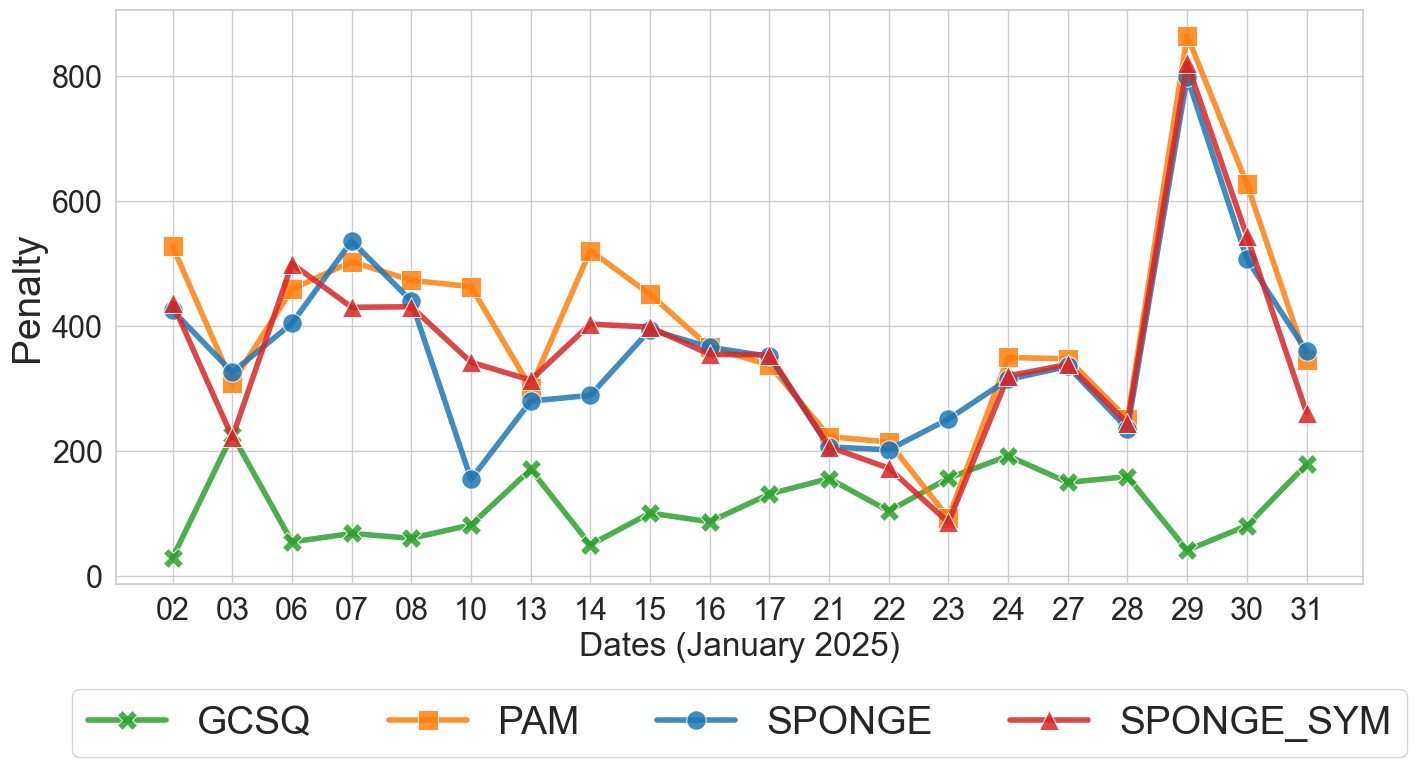

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid", font_scale=1.3)

markers = {
    'gcsq': 'X',
    'pam': 's',
    'sponge': 'o',
    'sponge_sym': '^'
}

colors = {
    'gcsq': '#2ca02c',      
    'pam': '#ff7f0e',       
    'sponge': '#1f77b4',    
    'sponge_sym': '#d62728' 
}

for algo in ['gcsq', 'pam', 'sponge', 'sponge_sym']:
    # Format date as 'Jan-DD'
    formatted_dates = pd.to_datetime(penalty_df['date']).dt.strftime('%d')
    sns.lineplot(
        x=formatted_dates, y=penalty_df[algo], 
        label=algo.upper(), marker=markers[algo], linewidth=4, alpha=0.85,
        color=colors[algo]
    )
    # Increase marker size for better visibility
    plt.setp(plt.gca().lines[-1], markersize=14)
plt.xlabel('Dates (January 2025)', fontsize=24)
plt.ylabel('Penalty', fontsize=28)

plt.xticks(rotation=0, fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.150),
    ncol=4,
    fontsize=28,
    title_fontsize=22,
    frameon=True
)
plt.savefig('clustering_penalties.png', bbox_inches='tight', dpi=300)
plt.show()
